In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os
import warnings
from collections import Counter, defaultdict
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.model_selection import KFold, cross_val_score, ShuffleSplit, LeaveOneOut
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='notebook', style='white', rc={"font.family": "DejaVu Serif"})

# Load, format, and regress data

## Spike decoding method

In [24]:
def regress_spikes_block(variables, data_type, alpha=1.0, nef_spikes='vwa', 
                         random_state=42, nef_downsample=True):
    rng = np.random.default_rng(seed=random_state)
    predictions = []
    for monkey in ['V', 'W']:
        for session in range(4):
            session_data = {}
            if data_type == 'nef' and nef_downsample:
                # Match NEF neuron count to monkey once per session
                x_monkey = np.load(f"data/emp/monkey{monkey}_session{session}_block1_trial1_spikes_choice.npz")['spikes']
                with open(f"data/nef/monkey{monkey}_session{session}_block1_spikes.pkl", 'rb') as f:
                    spikes = pickle.load(f)
                x_nef = spikes[nef_spikes][1]
                idx_random = rng.choice(x_nef.shape[0], size=x_monkey.shape[0], replace=False)
            for block in range(1, 25):
                session_data[block] = {}
                try:
                    file = f"monkey{monkey}_session{session}_block{block}"
                    if data_type == 'monkey':
                        for trial in range(1, 81):
                            x = np.load(f"data/emp/{file}_trial{trial}_spikes_choice.npz")['spikes']
                            y_dict = pd.read_pickle(f"data/rl/{file}_trial{trial}_values.pkl")
                            session_data[block][trial] = (x, {v: y_dict[v] for v in variables})
                    elif data_type == 'nef':
                        with open(f"data/nef/{file}_spikes.pkl", "rb") as f:
                            spikes = pickle.load(f)
                        for trial in range(1, 81):
                            x = spikes[nef_spikes][trial]
                            if nef_downsample:
                                x = x.copy()[idx_random]
                            y_dict = pd.read_pickle(f"data/nef/{file}_values.pkl").query("trial == @trial")
                            session_data[block][trial] = (x, {v: y_dict[v] for v in variables})
                except Exception:
                    session_data[block] = None

            # --- Clean incomplete blocks ---
            session_data = {b: d for b, d in session_data.items() if d and len(d) == 80}
            blocks = sorted(session_data.keys())
            if len(blocks) < 2:
                continue  # not enough blocks for LOO

            # --- Leave-One-Block-Out CV ---
            loo = LeaveOneOut()
            for train_idx, test_idx in loo.split(blocks):
                train_blocks = [blocks[i] for i in train_idx]
                test_blocks = [blocks[i] for i in test_idx]
                X_train = []
                Y_train = {v: [] for v in variables}
                for block in train_blocks:
                    for trial, (x, y_dict) in session_data[block].items():
                        X_train.append(x)
                        for v in variables:
                            Y_train[v].append(y_dict[v])
                models = {}
                for v in variables:
                    model = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
                    model.fit(X_train, Y_train[v])
                    models[v] = model
                for block in test_blocks:
                    for trial, (x, y_dict) in session_data[block].items():
                        row = {'monkey': monkey, 'session': session, 'block': block, 'trial': trial}
                        for v in variables:
                            row[v] = models[v].predict([x])[0]
                        predictions.append(row)

    df_pred = (pd.DataFrame(predictions).sort_values(['monkey', 'session', 'block', 'trial']).reset_index(drop=True))
    return df_pred

In [3]:
def regress_spikes_trial(variables, data_type='monkey', cv_type='none', holdout_frac=0.1, alpha=1.0,
                           nef_spikes='vwa', random_state=42, nef_downsample=True):
    rng = np.random.default_rng(seed=random_state)
    predictions = []
    for monkey in ['V', 'W']:
        for session in range(4):
            all_X, all_Y = [], {v: [] for v in variables}
            all_block, all_trial = [], []
            if data_type=='nef' and nef_downsample:
                x_monkey = np.load(f"data/emp/monkey{monkey}_session{session}_block1_trial1_spikes_choice.npz")['spikes']
                with open(f"data/nef/monkey{monkey}_session{session}_block1_spikes.pkl", 'rb') as f:
                    spikes = pickle.load(f)
                x_nef = spikes[nef_spikes][1]
                idx_random = rng.choice(x_nef.shape[0], size=x_monkey.shape[0], replace=False)
            for block in range(1, 25):
                try:
                    file = f"monkey{monkey}_session{session}_block{block}"
                    for trial in range(1, 81):
                        if data_type == 'monkey':
                            x = np.load(f"data/emp/{file}_trial{trial}_spikes_choice.npz")['spikes']
                            y_dict = pd.read_pickle(f"data/rl/{file}_trial{trial}_values.pkl")
                            y_dict = {v: y_dict[v] for v in variables}
                        elif data_type == 'nef':
                            with open(f"data/nef/{file}_spikes.pkl", 'rb') as f:
                                spikes = pickle.load(f)
                            x = spikes[nef_spikes][trial]
                            if nef_downsample:
                                x = x.copy()[idx_random]
                            y_dict = pd.read_pickle(f'data/nef/{file}_values.pkl').query("trial==@trial")
                            y_dict = {v: y_dict[v].values[0] for v in variables}
                        all_X.append(x)
                        for v in variables:
                            all_Y[v].append(y_dict[v])
                        all_block.append(block)
                        all_trial.append(trial)
                except Exception:
                    continue

            if len(all_X) == 0:
                continue

            all_X = np.array(all_X)
            n_trials = len(all_X)
            all_block = np.array(all_block)
            all_trial = np.array(all_trial)
            for v in variables:
                all_Y[v] = np.array(all_Y[v])

            if cv_type == 'trial':
                n_splits = int(np.ceil(1 / holdout_frac))
                ss = ShuffleSplit(n_splits=n_splits, test_size=holdout_frac, random_state=random_state)
                for train_idx, test_idx in ss.split(all_X):
                    models = {}
                    for v in variables:
                        model = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
                        model.fit(all_X[train_idx], all_Y[v][train_idx])
                        models[v] = model
                    for t in test_idx:
                        row = {'monkey': monkey,'session': session,'block': all_block[t],'trial': all_trial[t]}
                        for v in variables:
                            row[v] = models[v].predict(all_X[t].reshape(1, -1))[0]
                        predictions.append(row)
            elif cv_type == 'none':
                models = {}
                for v in variables:
                    model = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
                    model.fit(all_X, all_Y[v])
                    models[v] = model
                for t in range(n_trials):
                    row = {'monkey': monkey,'session': session,'block': all_block[t],'trial': all_trial[t]}
                    for v in variables:
                        row[v] = models[v].predict(all_X[t].reshape(1, -1))[0]
                    predictions.append(row)

    df_pred = pd.DataFrame(predictions).sort_values(['monkey', 'session', 'block', 'trial']).reset_index(drop=True)
    return df_pred

In [4]:
monkey_values_cv = regress_spikes_block(variables=['DeltaV_Stim', 'DeltaV_Act', 'omega'], data_type='monkey')

In [ ]:
monkey_values_cvt = regress_spikes_trial(variables=['DeltaV_Stim', 'DeltaV_Act', 'omega'], data_type='monkey', cv_type='trial')

In [25]:
nef_pred_cv = regress_spikes_block(variables=['dvs', 'dva', 'omega'], data_type='nef')

In [27]:
nef_pred_cva = regress_spikes_block(variables=['dvs', 'dva', 'omega'], data_type='nef', nef_spikes='a')

In [ ]:
nef_pred_cvt = regress_spikes_trial(variables=['dvs', 'dva', 'omega'], data_type='nef', cv_type='trial')

In [6]:
def load_rl_values():
    dfs = []
    variables = ['DeltaV_Stim', 'DeltaV_Act', 'DV_left', 'DV_right', 'omega']
    columns = ['monkey', 'session', 'block', 'trial'] + variables
    regression_dict = {}
    for monkey in ['V', 'W']:
        for session in range(4):
            for block in range(1,25):
                for trial in range(1, 81):
                    file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                    try:
                        values = pd.read_pickle(f'data/rl/{file}_values.pkl')
                        cols = [monkey, session, block, trial]
                        for var in variables:
                            cols.append(values[var].values[0])
                        dfs.append(pd.DataFrame([cols], columns=columns))
                    except:
                        pass
    rl_values = pd.concat(dfs, ignore_index=True)
    return rl_values

In [7]:
rl_values = load_rl_values()

In [8]:
def load_nef_values(load=False, monkeys=['V', 'W'], sessions=range(4), blocks=range(1,25)):
    if load:
        nef_values = pd.read_pickle("data/nef_values.pkl")
    else:
        emp = pd.read_pickle("data/empirical.pkl")
        nef_dfs = []
        rl_dfs = []
        for monkey in monkeys:
            for session in sessions:
                for block in blocks:
                    try:
                        file = f"monkey{monkey}_session{session}_block{block}"
                        nef_dfs.append(pd.read_pickle(f'data/nef/{file}_values.pkl').query("perturb==0.0"))
                    except:
                        pass
        nef_values = pd.concat(nef_dfs, ignore_index=True)
        nef_values.to_pickle("data/nef_values.pkl")
    return nef_values

In [9]:
nef_values = load_nef_values(False)
nef_values['model_type'] = 'nef'
nef_values.rename(columns={'w': 'omega'}, inplace=True)

# Plot P(better) and omega vs time

In [10]:
def add_columns(monkey_values, rl_values):
    emp = pd.read_pickle("data/empirical.pkl").copy()
    emp['trial_rev'] = emp['trial'].astype('int64') - emp['reversal_at_trial'].astype('int64')
    emp.rename(columns={'monkey_choice': 'cloc'}, inplace=True)
    emp.rename(columns={'monkey_accuracy': 'acc'}, inplace=True)
    emp.rename(columns={'reward': 'rew'}, inplace=True)
    emp['rew'] = emp['rew'].replace(0, -1)
    emp['cloc'] = emp['cloc'].replace('left', 0)
    emp['cloc'] = emp['cloc'].replace('right', 1)
    
    monkey_values = pd.merge(
        monkey_values,
        emp[["monkey", "session", "block", "trial", "block_type", "rew", "cloc", "clet", "acc", "trial_rev"]],
        # emp[["monkey", "session", "block", "trial", "block_type", "trial_rev", 'acc']],
        on=["monkey", "session", "block", "trial"],
        how="left"  # keeps all df1 rows, fills missing df2 values with NaN
    )
    monkey_values = monkey_values.dropna().reset_index(drop=True)

    rl_values = pd.merge(
        rl_values,
        emp[["monkey", "session", "block", "trial", "block_type", "trial_rev"]],
        on=["monkey", "session", "block", "trial"],
        how="left"  # keeps all df1 rows, fills missing df2 values with NaN
    )
    rl_values['model_type'] = 'rl'

    return monkey_values, rl_values

In [11]:
def smooth_split(df, y, ylabel, window=10):
    # Apply smoothing to trials on each side of the reversal independently
    left = df[df['trial_rev'] < 0].copy()
    right = df[df['trial_rev'] >= 0].copy()
    left[ylabel] = (left[y].rolling(window=window, center=True, min_periods=1).mean())
    right[ylabel] = (right[y].rolling(window=window, center=True, min_periods=1).mean())
    return pd.concat([left, right]).sort_index()

In [16]:
def plot_dynamics(monkey, nef, y, xlim=[-40,40], ylim=[0,1], yticks=5, ylabel='ylabel', filename='filename'):
    group_cols = ['monkey', 'session', 'block']
    monkey = monkey.sort_values(group_cols + ['trial'])
    nef = nef.sort_values(group_cols + ['trial'])

    monkey[f'{y}_smooth'] = (
        monkey.groupby(group_cols, group_keys=False)
        .apply(lambda g: smooth_split(g.drop(columns=group_cols), y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth']
    )

    nef[f'{y}_smooth'] = (
        nef.groupby(group_cols, group_keys=False)
        .apply(lambda g: smooth_split(g.drop(columns=group_cols), y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth']
    )

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(8, 4))
    sns.lineplot(monkey, x='trial_rev', y=f'{y}_smooth', hue='block_type', style='monkey',
                palette=[palette[3], palette[0]], ax=axes[0],
                hue_order=['what', 'where'], style_order=['V', 'W'])
    sns.lineplot(nef, x='trial_rev', y=f'{y}_smooth', hue='block_type', style='monkey',
                palette=[palette[3], palette[0]], ax=axes[1],
                hue_order=['what', 'where'], style_order=['V', 'W'])

    axes[0].set(ylabel=ylabel, xlabel='Trial', title='Monkey', xlim=xlim, ylim=ylim, yticks=np.linspace(ylim[0], ylim[1], yticks))
    axes[1].set(xlabel='Trial', title='NEF')
    # axes[0].axhline(0.5, ls=':', color='k')
    # axes[1].axhline(0.5, ls=':', color='k')
    axes[0].axvline(0, ls=':', color='k')
    axes[1].axvline(0, ls=':', color='k')
    axes[0].get_legend().remove()
    plt.legend(ncol=2)
    fig.tight_layout()
    plt.show()
    fig.savefig(f"plots/{filename}.pdf")

In [13]:
monkey_values_rev, rl_values_rev = add_columns(monkey_values_cv, rl_values)

/tmp/ipykernel_3011436/4062420662.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  emp['cloc'] = emp['cloc'].replace('right', 1)


/tmp/ipykernel_3011436/4204626537.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: smooth_split(g.drop(columns=group_cols), y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth']
/tmp/ipykernel_3011436/4204626537.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: smooth_split(g.drop(columns=group_cols), y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth']


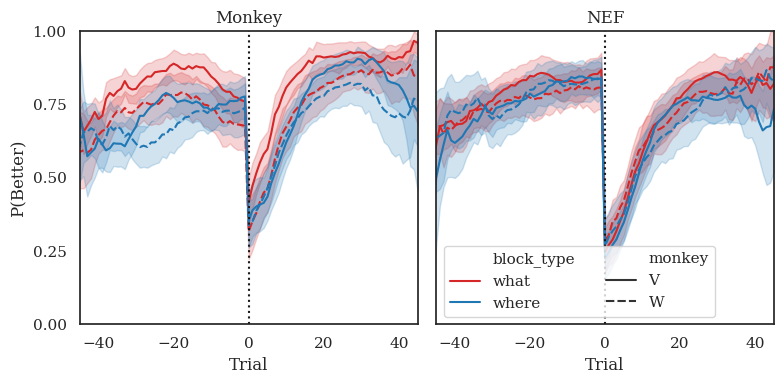

In [17]:
plot_dynamics(monkey_values_rev, nef_values, y='acc', xlim=[-45,45], ylabel='P(Better)', filename="Pbetter_vs_trial")

/tmp/ipykernel_3011436/4204626537.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: smooth_split(g.drop(columns=group_cols), y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth']
/tmp/ipykernel_3011436/4204626537.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: smooth_split(g.drop(columns=group_cols), y=y, ylabel=f'{y}_smooth'))[f'{y}_smooth']


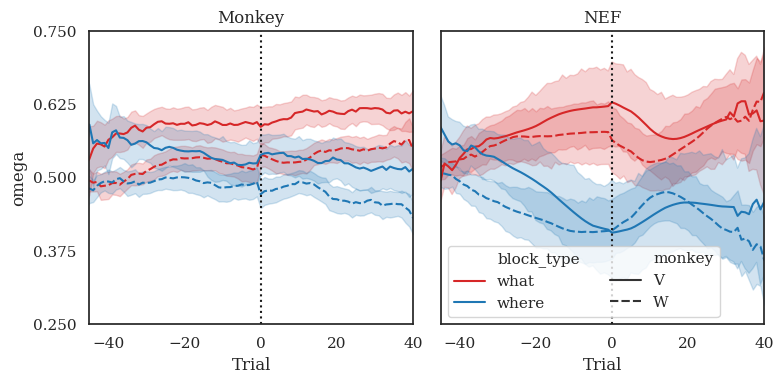

In [18]:
plot_dynamics(monkey_values_rev, nef_values, y='omega', xlim=[-45,40], ylim=[0.25, 0.75], ylabel='omega', filename="omega_vs_trial")

# Plot fraction of Q_total vs omega

In [19]:
def plot_fraction_Qtotal(nef_values, rl_values, monkey_values):
    nef_w = nef_values['omega'].to_numpy()
    nef_dvs = np.abs(nef_values['va'].to_numpy() - nef_values['vb'].to_numpy())
    nef_dva = np.abs(nef_values['vl'].to_numpy() - nef_values['vr'].to_numpy())
    nef_p_stim = nef_dvs / (nef_dvs + nef_dva)
    nef_p_act = nef_dva / (nef_dvs + nef_dva)
    
    rl_w = rl_values['omega'].to_numpy()
    rl_dvs = np.abs(rl_values['DeltaV_Stim'].to_numpy())
    rl_dva = np.abs(rl_values['DeltaV_Act'].to_numpy())
    rl_p_stim = rl_dvs / (rl_dvs + rl_dva)
    rl_p_act = rl_dva / (rl_dvs + rl_dva)
    
    monkey_w = monkey_values['omega'].to_numpy()
    monkey_dvs = np.abs(monkey_values['DeltaV_Stim'].to_numpy())
    monkey_dva = np.abs(monkey_values['DeltaV_Act'].to_numpy())
    monkey_p_stim = monkey_dvs / (monkey_dvs + monkey_dva)
    monkey_p_act = monkey_dva / (monkey_dvs + monkey_dva)
    
    w_bins = np.linspace(0, 1, 20)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,3), sharex=True, sharey=True)
    sns.regplot(x=rl_w, y=rl_p_stim, x_bins=w_bins, ax=axes[0], color=palette[0], scatter_kws={"s": 1}, label='RL')
    sns.regplot(x=rl_w, y=rl_p_act, x_bins=w_bins, ax=axes[1], color=palette[0], scatter_kws={"s": 1}, label='RL')
    sns.regplot(x=nef_w, y=nef_p_stim, x_bins=w_bins, ax=axes[0], color=palette[1], scatter_kws={"s": 1}, label='NEF')
    sns.regplot(x=nef_w, y=nef_p_act, x_bins=w_bins, ax=axes[1], color=palette[1], scatter_kws={"s": 1}, label='NEF')
    sns.regplot(x=monkey_w, y=monkey_p_stim, x_bins=w_bins, ax=axes[0], color=palette[2], scatter_kws={"s": 1}, label='Monkey')
    sns.regplot(x=monkey_w, y=monkey_p_act, x_bins=w_bins, ax=axes[1], color=palette[2], scatter_kws={"s": 1}, label='Monkey')
    axes[0].set(ylabel=r"Fraction of $Q_{total}$", xlim=(0.2, 0.8), ylim=(0.2, 0.8), title=r"$Q_{stim}$", xlabel=r'$\omega$')
    axes[1].set(xlim=(0.2, 0.8), ylim=(0.2, 0.8), title=r"$Q_{loc}$", xlabel=r'$\omega$')
    axes[0].legend()
    plt.tight_layout()
    fig.savefig("plots/qtotal_vs_omega.pdf")

/tmp/ipykernel_3011436/3740080227.py:11: RuntimeWarning: invalid value encountered in divide
  rl_p_stim = rl_dvs / (rl_dvs + rl_dva)
/tmp/ipykernel_3011436/3740080227.py:12: RuntimeWarning: invalid value encountered in divide
  rl_p_act = rl_dva / (rl_dvs + rl_dva)


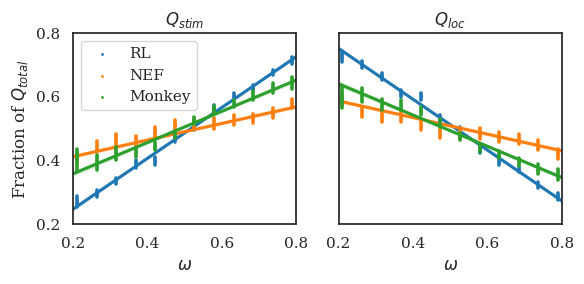

In [20]:
plot_fraction_Qtotal(nef_values, rl_values, monkey_values_cv)

# Plot decoding acccuracy vs omega

In [21]:
def plot_decoding_accuracy_vs_omega_general(predicted_df, true_df, data_type='monkey', filename='filename'):
    """
    Plot R² (decoding accuracy) vs. omega bins with error bars,
    coloring each omega_bin according to the 'coolwarm' palette.
    """
    # --- Determine column names depending on data type ---
    if data_type == 'monkey':
        x_cols = ['DeltaV_Act', 'DeltaV_Stim']
        xlabel = r'$\omega$ bin'
        ylabel = 'Monkey Decoding Accuracy\n'+r'(cross-validated $R^2$)'
    elif data_type == 'nef':
        x_cols = ['dva', 'dvs']
        xlabel = r'$\omega$ bin'
        ylabel = 'NEF Decoding Accuracy\n'+r'(cross-validated $R^2$)'
    else:
        raise ValueError("data_type must be 'monkey' or 'nef'")

    # --- Bin omega into 5 bins ---
    omega = true_df['omega']
    mask_low = omega < 0.45
    mask_high = omega > 0.55
    mask_mid = (omega >= 0.45) & (omega <= 0.55)
    med_low = omega[mask_low].median()
    med_high = omega[mask_high].median()
    
    true_df = true_df.copy()
    true_df['omega_bin'] = np.nan
    true_df.loc[mask_low & (omega <= med_low), 'omega_bin'] = 1
    true_df.loc[mask_low & (omega > med_low), 'omega_bin'] = 2
    true_df.loc[mask_mid, 'omega_bin'] = 3
    true_df.loc[mask_high & (omega <= med_high), 'omega_bin'] = 4
    true_df.loc[mask_high & (omega > med_high), 'omega_bin'] = 5
    true_df['omega_bin'] = true_df['omega_bin'].astype(int)

    # --- Merge predicted and true data ---
    combined = pd.merge(
        true_df[['monkey', 'session', 'block', 'trial', 'omega', 'omega_bin', x_cols[0], x_cols[1]]],
        predicted_df[['monkey', 'session', 'block', 'trial', x_cols[0], x_cols[1]]],
        on=['monkey', 'session', 'block', 'trial'],
        suffixes=('_true', '_pred')
    )

    # --- Compute R² per omega_bin ---
    omega_bins = sorted(combined['omega_bin'].unique())
    r2_act_vals = []
    r2_stim_vals = []
    for omega_bin in omega_bins:
        df_bin_act = combined.query("omega_bin == @omega_bin")[[f"{x_cols[0]}_true", f"{x_cols[0]}_pred"]]
        df_bin_stim = combined.query("omega_bin == @omega_bin")[[f"{x_cols[1]}_true", f"{x_cols[1]}_pred"]]

        r2_act = r2_score(df_bin_act[f"{x_cols[0]}_true"], df_bin_act[f"{x_cols[0]}_pred"]) if len(df_bin_act) > 1 else np.nan
        r2_stim = r2_score(df_bin_stim[f"{x_cols[1]}_true"], df_bin_stim[f"{x_cols[1]}_pred"]) if len(df_bin_stim) > 1 else np.nan
        r2_act_vals.append(r2_act)
        r2_stim_vals.append(r2_stim)

    # --- Plot R² vs omega_bin with colors from palette ---
    palette = sns.color_palette("coolwarm", 5)
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)

    for i, omega_bin in enumerate(omega_bins):
        axes[0].errorbar(omega_bin, r2_act_vals[i], 
                         yerr=np.nanstd(r2_act_vals)/np.sqrt(len(r2_act_vals)), 
                         fmt='o', color=palette[i], capsize=5)
        axes[1].errorbar(omega_bin, r2_stim_vals[i], 
                         yerr=np.nanstd(r2_stim_vals)/np.sqrt(len(r2_stim_vals)), 
                         fmt='o', color=palette[i], capsize=5)

    axes[0].set_xlabel(None)
    axes[1].set_xlabel(None)
    axes[0].set_ylabel(ylabel)
    axes[0].set_title(r'$\Delta Q_{Act}$')
    axes[1].set_title(r'$\Delta Q_{Stim}$')
    xtick_labels = [rf'$\omega_{i}$' for i in omega_bins]
    axes[0].set_xticks(omega_bins)
    axes[1].set_xticks(omega_bins)
    axes[0].set_xticklabels(xtick_labels)
    axes[1].set_xticklabels(xtick_labels)
    plt.tight_layout()
    plt.show()
    fig.savefig(f"plots/{filename}.pdf")

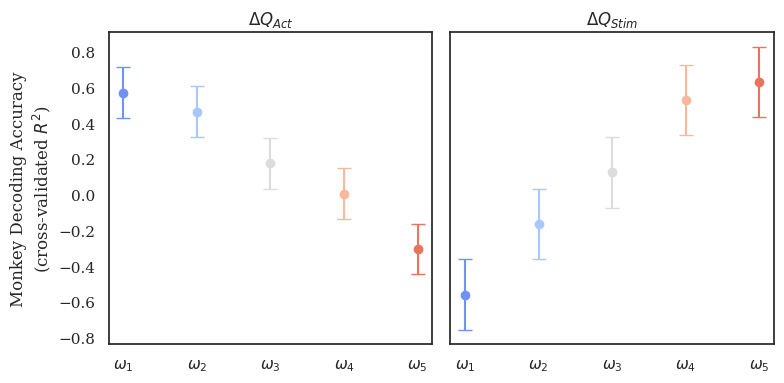

In [22]:
plot_decoding_accuracy_vs_omega_general(monkey_values_cv, rl_values, data_type='monkey', filename="monkey_cross_decoding")

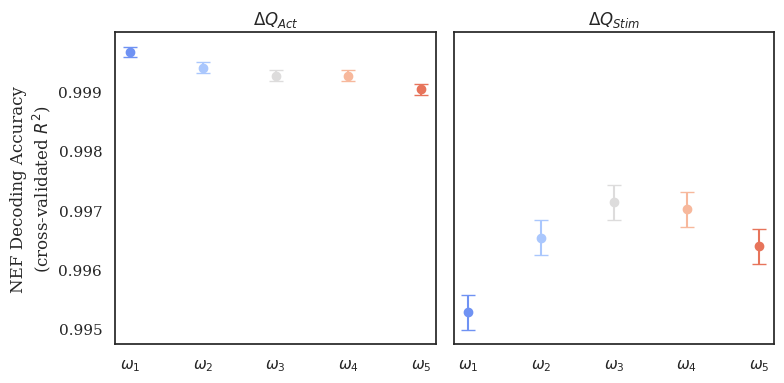

In [26]:
plot_decoding_accuracy_vs_omega_general(nef_pred_cv, nef_values, data_type='nef', filename="nef_cross_decoding")

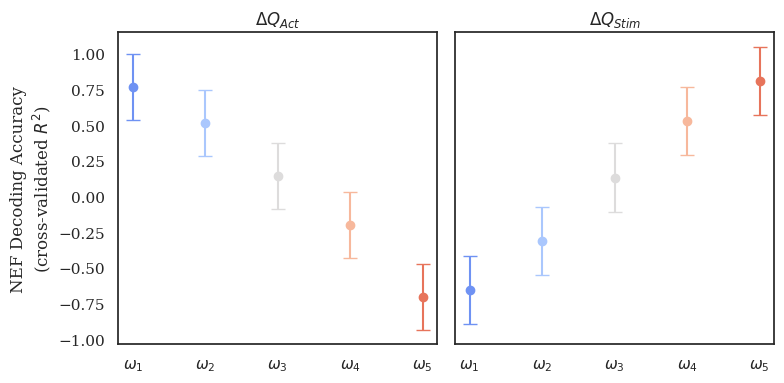

In [28]:
plot_decoding_accuracy_vs_omega_general(nef_pred_cva, nef_values, data_type='nef', filename="nef_cross_decoding")